# Churn Modeling - Preliminary Data Exploration

This full project explores techniques in developing churn models. This notebook is the preliminary step in getting acquainted with the data, found in a tutorial on the Dataiku website (https://www.dataiku.com/learn/guide/tutorials/churn-prediction.html#loading). The data is toy data, which resembles data collected from an e-commerce website. 
This project is a component of the Springboard Data Intensive Course.

In [1]:
%matplotlib notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from __future__ import print_function

In [4]:
sns.set_context("talk")

## Read in data, check for missing values

In [5]:
#data is comma-delimited csv, with headers in the first line
df_events = pd.read_csv('events.csv')
df_products = pd.read_csv('products.csv')

In [6]:
df_events.head()

,user_id,event_timestamp,event_type,product_id,seller_id
0,53189,2014-09-08 22:00:00,product_page,399135.0,118464.0
1,23481,2014-09-08 14:00:00,seller_page,NaN,255.0
2,33110,2014-09-08 18:00:00,seller_page,NaN,96245.0
3,1038,2014-09-08 21:00:00,seller_page,NaN,90112.0
4,133215,2014-09-08 15:00:00,seller_page,NaN,1744.0


In [7]:
#any missing values?
print(df_events.user_id.isnull().any())
print(df_events.event_timestamp.isnull().any())
print(df_events.event_type.isnull().any())
print(df_events.seller_id.isnull().any())

False
True
False
False


In [8]:
#how many missing values for event_timestamp
print(len(df_events[df_events.event_timestamp.isnull()]))
df_events[df_events.event_timestamp.isnull()].head(1)
#some data does not have a timestamp.

5377


,user_id,event_timestamp,event_type,product_id,seller_id
2480086,125064,NaN,buy_order,85785.0,127651.0


In [9]:
#what are possible values for event_type
set(df_events.event_type)

{'buy_order', 'product_page', 'seller_page'}

In [10]:
#Perhaps seller_id is also suitable as an integer. are all values whole numbers?
sell_id = df_events.seller_id
sell_id[np.floor(sell_id) != sell_id]

Series([], Name: seller_id, dtype: float64)

In [11]:
#Perhaps product_id is also suitable as an integer, but it contains NaN which must be floats. 
#still, are all values whole numbers?
prod_id = df_events.product_id
prod_id = prod_id.dropna()
prod_id[np.floor(prod_id) != prod_id]

Series([], Name: product_id, dtype: float64)

In [12]:
df_products.head()

,product_id,category_id_0,category_id_1,category_id_2,price
0,0,9.0,38,166,20.04
1,1,5.0,37,109,7.02
2,2,6.0,19,196,10.00
3,3,4.0,12,100,12.00
4,4,1.0,39,38,0.01


In [13]:
#any missing values?
print(df_products.product_id.isnull().any())
print(df_products.category_id_0.isnull().any())
print(df_products.category_id_1.isnull().any())
print(df_products.category_id_2.isnull().any())
print(df_products.price.isnull().any())

False
True
False
False
True


In [14]:
#how many missing values for category_id
print(len(df_products[df_products.category_id_0.isnull()]))
df_products[df_products.category_id_0.isnull()].head(1)

204


,product_id,category_id_0,category_id_1,category_id_2,price
1949,1949,NaN,104,117,0.01


In [15]:
#how many missing values for price
print(len(df_products[df_products.price.isnull()]))
df_products[df_products.price.isnull()].head(1)

6359


,product_id,category_id_0,category_id_1,category_id_2,price
7,7,1.0,31,152,NaN


In [16]:
#Perhaps category_id_0 is also suitable as an integer, though the column contains NaNs so it must be float. 
#still, are all values whole numbers?
prod_cat0 = df_products.category_id_0
prod_cat0 = prod_cat0.dropna()
prod_cat0[np.floor(prod_cat0) != prod_cat0]

Series([], Name: category_id_0, dtype: float64)

## Clean up formats

In [17]:
#Need to convert event_timestamp from string to datetime, 
#and convert categorical data in event_type to dummy variables (column of booleans for each category).
df_events = pd.concat([df_events,pd.get_dummies(df_events.event_type)],axis=1)
df_events.event_timestamp = pd.to_datetime(df_events.event_timestamp)
df_events.head()

,user_id,event_timestamp,event_type,product_id,seller_id,buy_order,product_page,seller_page
0,53189,2014-09-08 22:00:00,product_page,399135.0,118464.0,0,1,0
1,23481,2014-09-08 14:00:00,seller_page,NaN,255.0,0,0,1
2,33110,2014-09-08 18:00:00,seller_page,NaN,96245.0,0,0,1
3,1038,2014-09-08 21:00:00,seller_page,NaN,90112.0,0,0,1
4,133215,2014-09-08 15:00:00,seller_page,NaN,1744.0,0,0,1


In [18]:
#Convert seller_id from float to int
df_events.seller_id = df_events.seller_id.astype(df_events.user_id.dtype)
df_events.seller_id.dtype

dtype('int64')

### Check if interpretations and assumptions about data are correct

In [19]:
#product_id has a value when event_type is "product page"
~(df_events.product_page & df_events.product_id.isnull()).any()

True

In [20]:
#product_id value range in df_events same as product id range in df_products
print(df_events.product_id.max())
print(df_products.product_id.max())

837867.0
837867


## Data Exploration

### Events

<IPython.core.display.Javascript object>


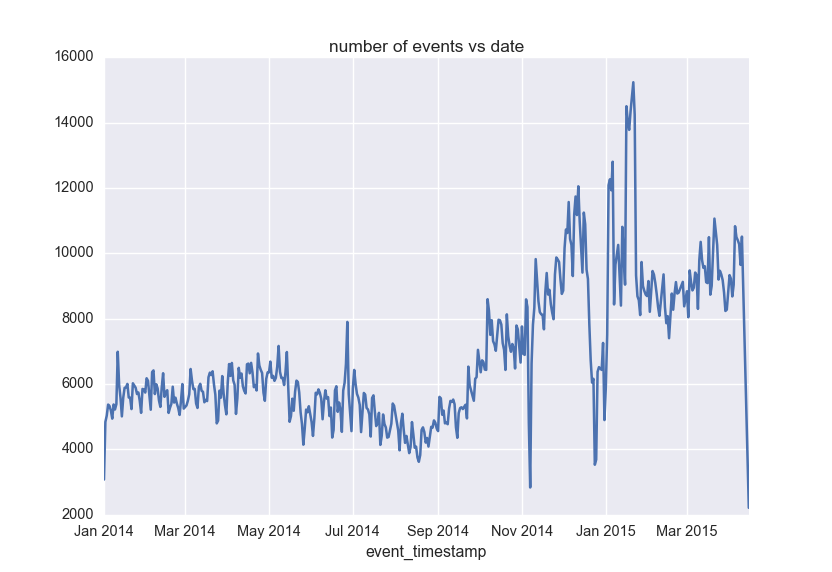

In [21]:
#frequency of events
df = df_events
plt.figure()
df.groupby(df.event_timestamp.dt.date).size().plot()
plt.title('number of events vs date')

<IPython.core.display.Javascript object>


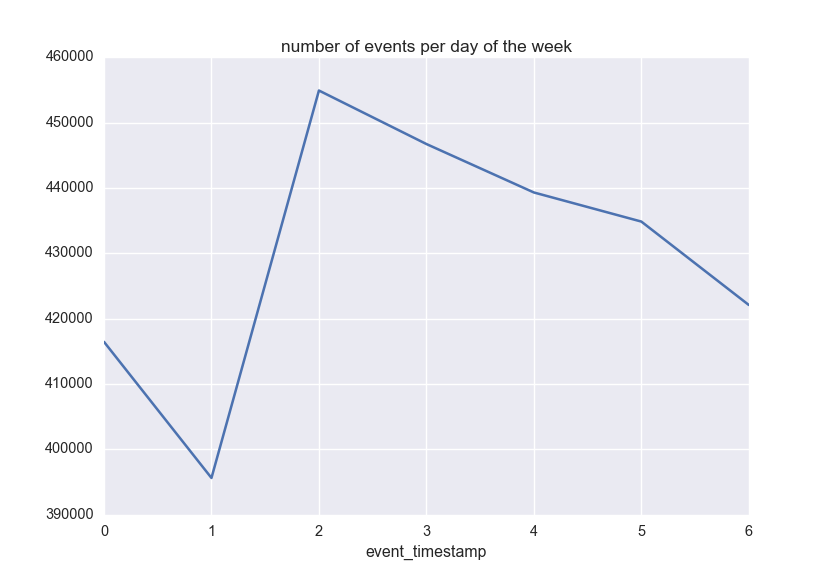

In [22]:
#seems there is a short term cyclic signal, by week?
df = df_events
plt.figure()
df.groupby(df.event_timestamp.dt.dayofweek).size().plot()
plt.title('number of events per day of the week')

<IPython.core.display.Javascript object>


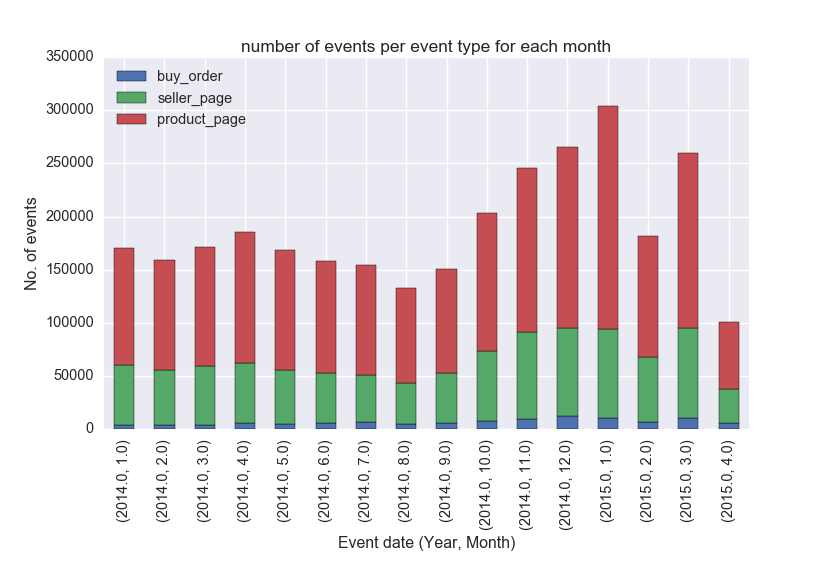

In [23]:
#frequency of events for each type of event
cols = list(set(df_events.event_type))
cols.extend(['event_timestamp'])
df = df_events[cols]
ax = df.groupby([df.event_timestamp.dt.year,df.event_timestamp.dt.month]).sum().plot.bar(stacked=True)
ax.set_xlabel('Event date (Year, Month)')
ax.set_ylabel('No. of events')
plt.gcf().subplots_adjust(bottom=0.25)
plt.title('number of events per event type for each month')

### User

<IPython.core.display.Javascript object>


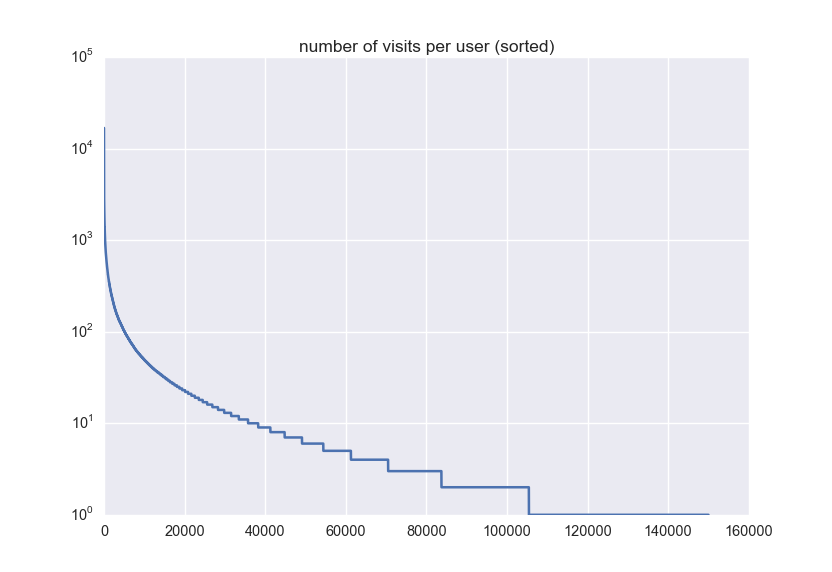

In [24]:
#distribution of user visits
df = df_events
plt.figure()
plt.plot(df.groupby(df.user_id).size().sort_values(ascending=False).values)
plt.yscale('log')
plt.title('number of visits per user (sorted)')

In [25]:
#time between user visits
#calculate by copying and offsetting event timestamp column - then calculate difference (plus other steps)
df = df_events[['user_id','event_timestamp']]
df = df.sort_values(['user_id','event_timestamp']).reset_index()

In [26]:
#duplicate and offset by one row, pad last with last element again
df['user_id2'] = pd.Series(df.ix[1:,'user_id'].append(pd.Series(
                               df.ix[df.index[-1],'user_id']), ignore_index=True),
                               index=range(len(df)))
df['event_timestamp2'] = pd.Series(df.ix[1:,'event_timestamp'].append(pd.Series(
                                df.ix[df.index[-1],'event_timestamp']), ignore_index=True),
                                index=range(len(df)))

In [27]:
df_evd = df[(df.user_id == df.user_id2) & (df.event_timestamp != df.event_timestamp2)].copy()
del df_evd['user_id2']
df_evd['event_diff'] = df_evd.event_timestamp2 - df_evd.event_timestamp

<IPython.core.display.Javascript object>


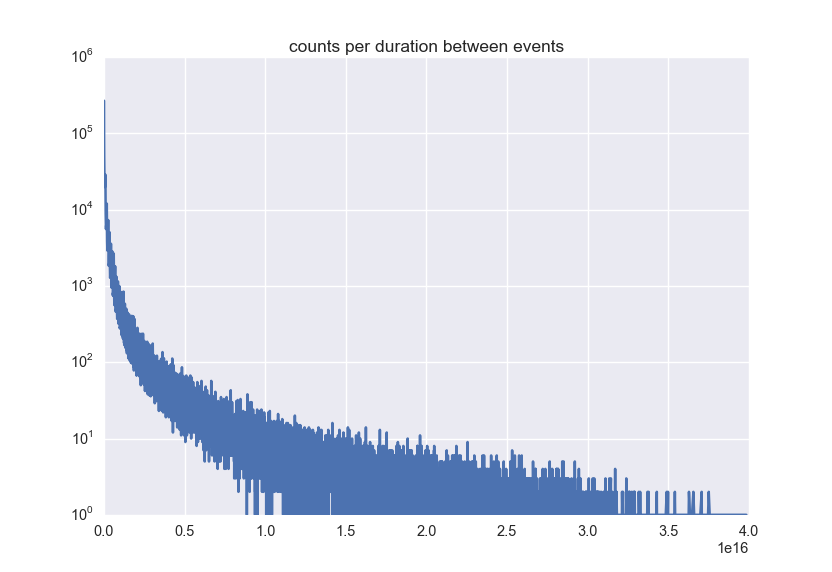

In [28]:
plt.figure()
plt.plot(df_evd.groupby(df_evd.event_diff).size())
plt.yscale('log')
plt.title('counts per duration between events')

### Products

<IPython.core.display.Javascript object>


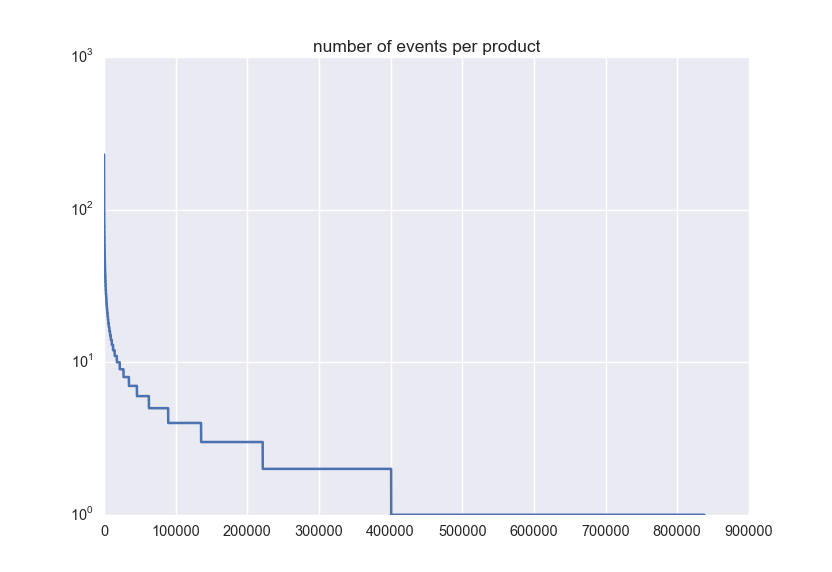

In [29]:
#most popular products?
df = df_events
fig = plt.figure()
plt.plot(df.groupby(df.product_id).size().sort_values(ascending=False).values)
plt.yscale('log')
plt.title('number of events per product')

### Seller

<IPython.core.display.Javascript object>


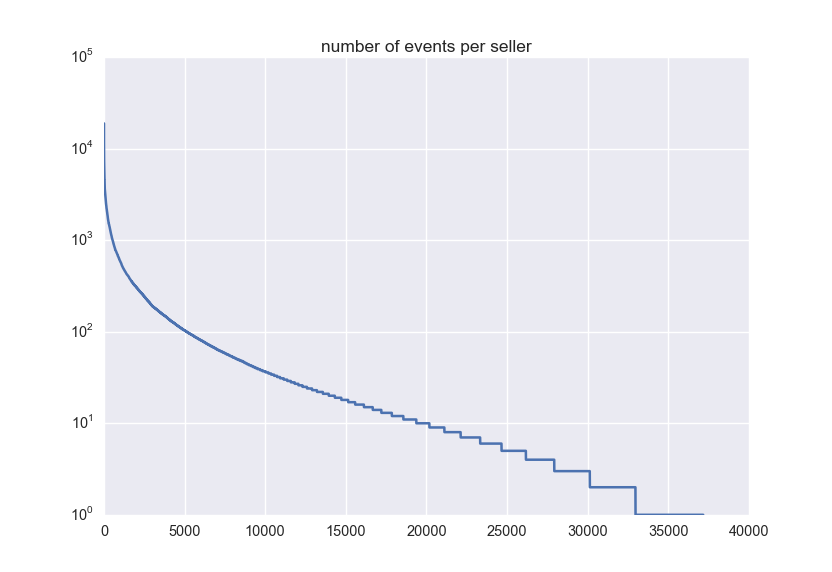

In [30]:
#most popular seller?
df = df_events
fig = plt.figure()
plt.semilogy(df.groupby(df.seller_id).size().sort_values(ascending=False).values)
plt.title('number of events per seller')

### Price

In [51]:
#distribution of price
df = df_products
print('mean: {}'.format(df.price.mean()))
print('median: {}'.format(df.price.median()))

mean: 7190.103273972517
median: 15.07


In [52]:
df_price = df.groupby(df.price // 10 * 10).size()
df_price

price
0.0           249676
10.0          261869
20.0          126064
30.0           77307
40.0           28233
50.0           25175
60.0           10035
70.0            9398
80.0            7458
90.0            5663
100.0           2754
110.0           2401
120.0           4348
130.0           1158
140.0           1887
150.0           2385
160.0           1180
170.0            906
180.0           1150
190.0            923
200.0           1245
210.0            571
220.0            187
230.0            577
240.0            236
250.0           1017
260.0            250
270.0             72
280.0            418
290.0            265
               ...  
37080.0            2
42460.0            1
51950.0            1
55060.0            1
67400.0            1
80320.0           11
99170.0            1
103420.0          32
139760.0           1
191350.0           1
195600.0           1
253800.0           1
437800.0           1
452040.0           1
792320.0           1
809840.0           1
999190.

<IPython.core.display.Javascript object>


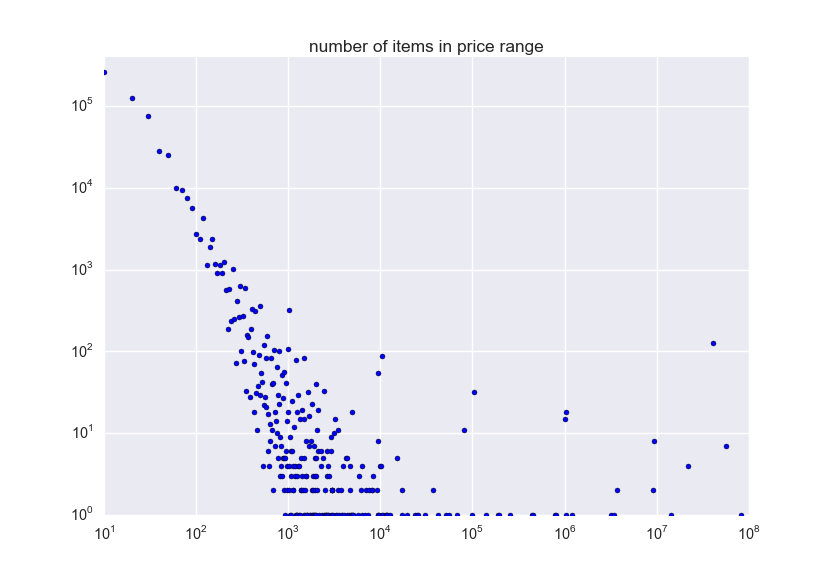

In [46]:
fig = plt.figure()
plt.scatter(df_price.index, df_price.values)
plt.xscale('log')
plt.yscale('log')
plt.axis([10,1e8,1,4e5])
plt.title('number of items in price range')